In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

#yen_futures.info()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures_1990 = yen_futures.loc["1990-01-01":, :]
yen_futures_1990.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

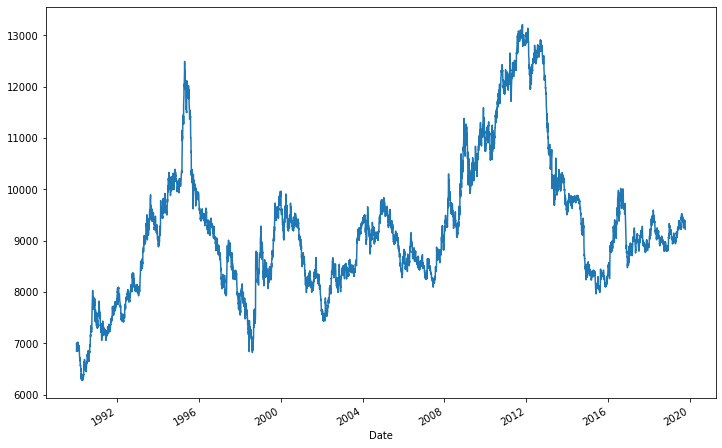

In [4]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE!

yen_futures_1990.Settle.plot(figsize=(12,8))

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
# YOUR CODE HERE!

settle_noise, settle_trend = sm.tsa.filters.hpfilter(yen_futures_1990["Settle"])

In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!

yen_futures_1990['settle_noise'] = settle_noise
yen_futures_1990['settle_trend'] = settle_trend
yen_futures_1990.drop(['Open', 'High', 
                'Low', 'Last', 'Change', 'Volume', 'Previous Day Open Interest'], axis=1, inplace=True)
yen_futures_1990.head()

/Users/alexbeckham/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/alexbeckham/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/alexbeckham/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


,Settle,settle_noise,settle_trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:xlabel='Date'>

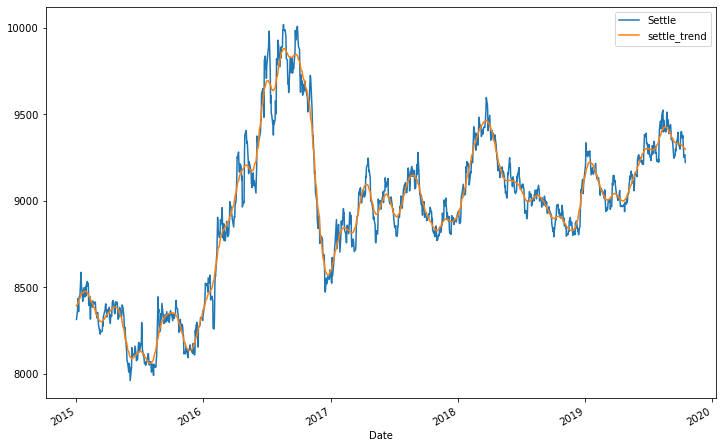

In [7]:
# Plot the Settle Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!

yen_futures_1990[['Settle', 'settle_trend']].loc["2015-01-01":,:].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

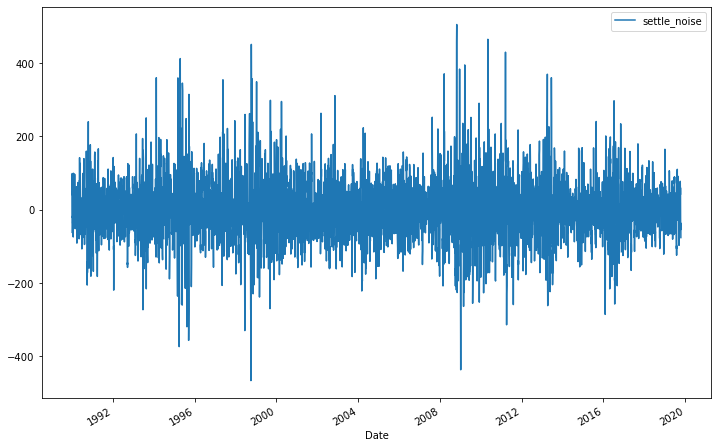

In [8]:
# Plot the Settle Noise
# YOUR CODE HERE!
yen_futures_1990[['settle_noise']].plot(figsize=(12,8))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [13]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [37]:
import statsmodels.api as sm


# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!
model = sm.tsa.ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
# YOUR CODE HERE!
results = model.fit()


/Users/alexbeckham/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [38]:
# Output model summary results:
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                10901
Model:                     ARMA(2, 1)   Log Likelihood              -11512.994
Method:                       css-mle   S.D. of innovations              0.696
Date:                Thu, 11 Mar 2021   AIC                          23035.987
Time:                        20:13:15   BIC                          23072.470
Sample:                             0   HQIC                         23048.284
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0116      0.007      1.748      0.080      -0.001       0.025
ar.L1.y       -0.6660      0.416     -1.600      0.110      -1.482       0.150
ar.L2.y       -0.0074      0.010     -0.770      0.441      -0.026       0.011
ma.L1.y        0.6611      0.416      1.588      0.112      -0.155       1.477
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5274           +0.0000j            1.5274            0.5000
AR.2          -88.8156           +0.0000j           88.8156            0.5000
MA.1           -1.5126           +0.0000j            1.5126            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

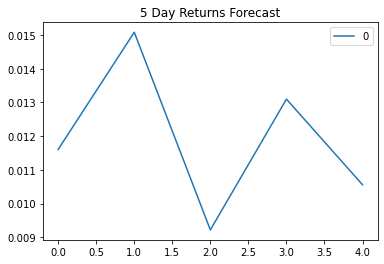

In [36]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [41]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!

model_arima = sm.tsa.ARIMA(yen_futures['Settle'], order=(5, 1, 1))

# Fit the model
# YOUR CODE HERE!
results_arima = model_arima.fit()


/Users/alexbeckham/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/alexbeckham/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

In [42]:
# Output model summary results:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                10901
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -59614.572
Method:                       css-mle   S.D. of innovations             57.385
Date:                Thu, 11 Mar 2021   AIC                         119245.144
Time:                        20:17:38   BIC                         119303.517
Sample:                             1   HQIC                        119264.818
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5345      0.526      1.017      0.309      -0.496       1.565
ar.L1.D.Settle     0.2259      0.595      0.380      0.704      -0.941       1.392
ar.L2.D.Settle    -0.0026      0.012     -0.223      0.824      -0.025       0.020
ar.L3.D.Settle    -0.0061      0.010     -0.594      0.552      -0.026       0.014
ar.L4.D.Settle    -0.0133      0.011     -1.244      0.214      -0.034       0.008
ar.L5.D.Settle    -0.0024      0.014     -0.178      0.859      -0.029       0.024
ma.L1.D.Settle    -0.2363      0.595     -0.397      0.691      -1.403       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9130           -1.4192j            2.3820           -0.1016
AR.2            1.9130           +1.4192j            2.3820            0.1016
AR.3           -1.7091           -3.0613j            3.5061           -0.3310
AR.4           -1.7091           +3.0613j            3.5061            0.3310
AR.5           -5.8700           -0.0000j            5.8700           -0.5000
MA.1            4.2311           +0.0000j            4.2311            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

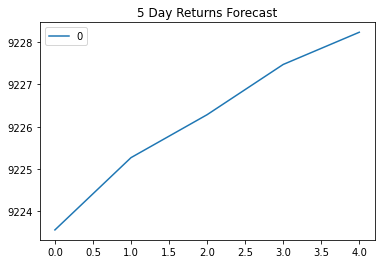

In [43]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
pd.DataFrame(results_arima.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [48]:
import arch 
from arch import arch_model

In [49]:
# Estimate a GARCH model:
# YOUR CODE HERE!
model_garch = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
# YOUR CODE HERE!
res = model_garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 174711882.24354458
Iteration:      2,   Func. Count:     13,   Neg. LLF: 12178.447445607038
Iteration:      3,   Func. Count:     21,   Neg. LLF: 17327.60825772252
Iteration:      4,   Func. Count:     27,   Neg. LLF: 10956.916738017393
Iteration:      5,   Func. Count:     33,   Neg. LLF: 18247.88939233959
Iteration:      6,   Func. Count:     39,   Neg. LLF: 10950.04562785471
Iteration:      7,   Func. Count:     45,   Neg. LLF: 10918.717427084151
Iteration:      8,   Func. Count:     50,   Neg. LLF: 10917.342514952654
Iteration:      9,   Func. Count:     55,   Neg. LLF: 10917.045414170212
Iteration:     10,   Func. Count:     60,   Neg. LLF: 10917.025826816576
Iteration:     11,   Func. Count:     65,   Neg. LLF: 10917.01057265629
Iteration:     12,   Func. Count:     70,   Neg. LLF: 10917.008656320479
Iteration:     13,   Func. Count:     75,   Neg. LLF: 6232640797.00273
Iteration:     14,   Func. Count:     86,   Neg. LLF: 116

In [50]:
# Summarize the model results
# YOUR CODE HERE!
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10917.0
Distribution:                  Normal   AIC:                           21842.0
Method:            Maximum Likelihood   BIC:                           21871.2
                                        No. Observations:                10901
Date:                Thu, Mar 11 2021   Df Residuals:                    10901
Time:                        20:21:47   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.6567e-03  3.287e-03      1.417      0.157 [-1.785e-03,1.110e-02]
alpha[1]       0.0404  1.388e-02      2.913  3.585e-03  [1.322e-02,6.764e-02]
alpha[2]   5.1841e-12  2.165e-02  2.395e-10      1.000 [-4.243e-02,4.243e-02]
beta[1]        0.9509  2.247e-02     42.328      0.000      [  0.907,  0.995]
=============================================================================

Covariance estimator: robust
"""

In [51]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [52]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [53]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.461108,7.507407,7.553026,7.597982,7.642288


In [54]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.461108
h.2,7.507407
h.3,7.553026
h.4,7.597982
h.5,7.642288


<AxesSubplot:>

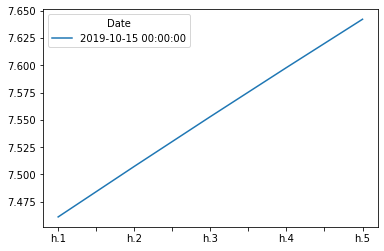

In [56]:
# Plot the final forecast
# YOUR CODE HERE!
final.plot()

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

Question: Based on your time series analysis, would you buy the yen now?
Answer: No, I would not buy the yen now because the ARMA model does not show increasing returns. 

Question: Is the risk of the yen expected to increase or decrease?
Answer: The GARCH model shows us that the risk is supposed to increase. 

Question: Based on the model evaluation, would you feel confident in using these models for trading?
Answer: p-value of the AR lag is 0.811
ARMA AIC 119245.144
ARMA BIC 119303.517

ARIMA AIC 83905.238
ARIMA BIC 83960.635
The lower the AIC & BIC, the better the accuracy. 

